In [118]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [119]:
def compute_gini_index_curve(image):
    # Calculate the histogram of the image
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    total_pixels = hist.sum()
    prob = hist / total_pixels  # Probability of each intensity level
    #prob[prob == 0] = np.nan  # Avoid log(0) by setting zero probabilities to NaN

    # Calculate Gini index for each intensity level
    gini_values = 1 - np.cumsum(prob**2) ## v1
    #gini_values = prob * (1 - prob)  # v3
    #gini_values = 1 - prob**2 ## v2
    #gini_values = np.nan_to_num(gini_values, nan=0.0)  # Replace NaNs with zero in entropy result

    return gini_values**2


def clip_and_slice_gini_curve(G, image, quantiles=[0.25, 0.5, 0.75]):
    # Step 1: Calculate the quantiles and clipping limit based on the Gini curve
    Q0, Q1, Q2, Q3 = np.quantile(G[G > 0], [0.0, quantiles[0], quantiles[1], quantiles[2]])
    #Cclip = (Q0 + Q1 + Q2 + Q3) / 4
    Cclip = (Q1 + 2 * Q2 + 2 * Q3) / 5
    #clipped_gini_curve = np.minimum(G, Cclip)
    clipped_gini_curve = np.maximum(np.minimum(G, Cclip), 0.05)

    # Step 2: Compute the histogram and weighted mean intensity
    hist, _ = np.histogram(image.flatten(), bins=256, range=[0, 256])
    intensity_levels = np.arange(256)
    mean_intensity = np.sum(intensity_levels * G) / np.sum(G)

    # Step 3: Compute the weighted standard deviation based on the Gini curve
    weighted_variance = np.sum(((intensity_levels - mean_intensity) ** 2) * hist) / np.sum(hist)
    std_intensity = np.sqrt(weighted_variance)

    # Step 4: Find the intensity levels with minimum and maximum Gini values in the clipped Gini curve
    non_zero_indices = np.nonzero(clipped_gini_curve)[0]  # Indices where Gini values > 0
    min_gini_index = non_zero_indices[np.argmin(clipped_gini_curve[non_zero_indices])]
    max_gini_index = non_zero_indices[np.argmax(clipped_gini_curve[non_zero_indices])]

    L_m = min_gini_index
    L_M = max_gini_index

    if L_m > L_M:
        L_m, L_M = L_M, L_m

    # Step 5: Calculate lower and upper limits based on SD
    L_l = int(L_m + std_intensity)
    L_H = int(L_M + std_intensity)

    return clipped_gini_curve, L_l, L_H

def equalize_gini_segments(image, clipped_gini_curve, lower_threshold, upper_threshold):
    # Step 1: Divide the Gini curve into three segments
    segments = [
        (0, max(0, lower_threshold)),
        (max(0, lower_threshold + 1), min(255, upper_threshold)),
        (min(255, upper_threshold + 1), 255)
    ]

    # Initialize an empty array to store the enhanced image
    equalized_image = np.zeros_like(image, dtype=np.float32)

    # Step 2: Calculate total Gini values for normalization
    total_gini = np.sum(clipped_gini_curve)

    # Step 3: Perform equalization for each segment
    for start, end in segments:
        mask = (image >= start) & (image <= end)
        if not np.any(mask):
            print("No mask found for segment:", (start, end))
            continue

        # Calculate normalized Gini values for the current segment
        segment_gini = clipped_gini_curve[start:end + 1]
        normalized_gini = segment_gini / total_gini

        # Calculate cumulative Gini values for each intensity level in the segment
        cumulative_gini_values = np.cumsum(normalized_gini) ** 0.8  # Use a non-linear scaling function or a weighted transformation that emphasizes contrast in the middle segment (where most information resides):

        # Apply the transformation function for the segment
        if start == 0:
            transformed_values = start + (end - start) * cumulative_gini_values
        elif start == max(0, lower_threshold + 1):
            transformed_values = start + (min(255, upper_threshold) - start) * cumulative_gini_values
        else:
            transformed_values = (min(255, upper_threshold + 1)) + (255 - min(255, upper_threshold + 1)) * cumulative_gini_values

        # Map the transformed values back to the segment in the image
        segment_pixels = image[mask]
        equalized_image[mask] = np.interp(segment_pixels, np.arange(start, end + 1), transformed_values)

    # Clip values to the range 0-255 and convert to uint8 for image representation
    return np.clip(equalized_image, 0, 255).astype(np.uint8)

def entropy_based_contrast_enhancement(image):
    # Convert to grayscale if the image has multiple channels (e.g., is color)
    if len(image.shape) == 3 and image.shape[2] == 3:
        grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        grayscale_image = image  # Image is already grayscale

    # Convert image to 8-bit if it’s in float format or not in the uint8 range
    if grayscale_image.dtype != np.uint8:
        #print("Converting image to 8-bit (0-255) range for processing.")
        grayscale_image = (grayscale_image * 255).astype(np.uint8)

    # Step 1: Compute entropy curve
    entropy_curve = compute_gini_index_curve(grayscale_image)

    # Step 2: Clip and slice the entropy curve
    clipped_entropy_curve, lower_thresh, upper_thresh = clip_and_slice_gini_curve(entropy_curve, grayscale_image)

    # Step 3: Equalize the image using the entropy segments
    enhanced_image = equalize_gini_segments(grayscale_image, clipped_entropy_curve, lower_thresh, upper_thresh)
    enhanced_image = cv2.addWeighted(grayscale_image, 0.4, enhanced_image, 0.6, 0)

    return enhanced_image


#### Moon

In [120]:
from skimage import data, img_as_float
image = data.moon()
image.shape

(512, 512)

(-0.5, 511.5, 511.5, -0.5)

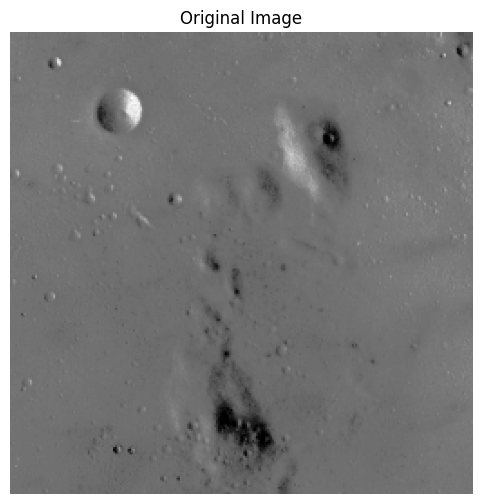

In [121]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.title('Original Image')
plt.imshow(image, cmap="gray")
plt.axis('off')

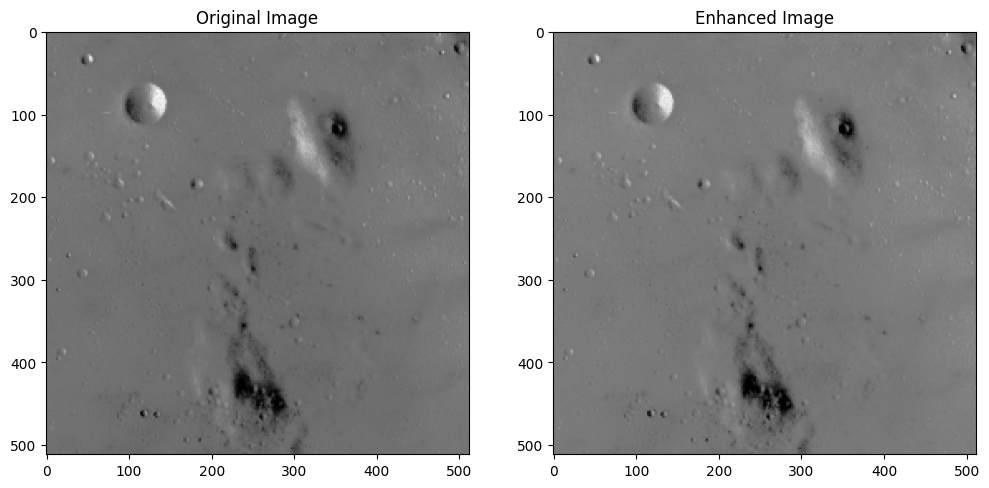

In [122]:
# Apply the entropy-based contrast enhancement
enhanced_image = entropy_based_contrast_enhancement(image)

# Show the original and enhanced images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(enhanced_image, cmap='gray')
plt.show()


### Evaluation
We use Berkley Segmentation Dataset (BSDS)

#### Dataset Download

In [123]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("balraj98/berkeley-segmentation-dataset-500-bsds500")

print("Path to dataset files:", path)

100%|██████████| 56.0M/56.0M [00:00<00:00, 59.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1


In [124]:
!mv /root/.cache/kagglehub/datasets/balraj98/berkeley-segmentation-dataset-500-bsds500/versions/1/ .

In [125]:
!mv 1 BSDS300

In [126]:
!ls BSDS300/images/test
!pwd

100007.jpg  118031.jpg	159002.jpg  196040.jpg	230098.jpg  289011.jpg	376086.jpg  69022.jpg
100039.jpg  118072.jpg	159022.jpg  196062.jpg	23050.jpg   290035.jpg	384022.jpg  70011.jpg
100099.jpg  120003.jpg	160006.jpg  196088.jpg	232076.jpg  29030.jpg	384089.jpg  70090.jpg
10081.jpg   120093.jpg	16004.jpg   198087.jpg	235098.jpg  296028.jpg	385022.jpg  71076.jpg
101027.jpg  123057.jpg	160067.jpg  20069.jpg	238025.jpg  296058.jpg	388006.jpg  71099.jpg
101084.jpg  128035.jpg	16068.jpg   201080.jpg	243095.jpg  302022.jpg	388018.jpg  77062.jpg
102062.jpg  130014.jpg	161045.jpg  2018.jpg	246009.jpg  306051.jpg	388067.jpg  78098.jpg
103006.jpg  130066.jpg	163004.jpg  202000.jpg	247003.jpg  306052.jpg	393035.jpg  79073.jpg
103029.jpg  134049.jpg	163096.jpg  206062.jpg	247012.jpg  3063.jpg	41006.jpg   80085.jpg
103078.jpg  134067.jpg	164046.jpg  206097.jpg	249021.jpg  309040.jpg	41029.jpg   80090.jpg
104010.jpg  140006.jpg	168084.jpg  207038.jpg	250047.jpg  317043.jpg	41085.jpg   8068.jpg
104055

In [127]:
from skimage import img_as_float
from skimage.color import rgb2gray
from skimage.io import imread_collection
import os

# Define the path where BSDS300 images are located
dataset_dir = "/content/BSDS300/images/test"  # Update with the correct path

def load_bsds_images():
    # Ensure the dataset directory exists
    if not os.path.exists(dataset_dir):
        print("Dataset directory not found. Please download BSDS300 and place it in the specified path.")
        return []

    # Load all JPEG images in the dataset directory
    image_files = f"{dataset_dir}/*.jpg" #f"{dataset_dir}/*.png"
    images = imread_collection(image_files)  # Loads all .jpg files in the directory
    return [rgb2gray(img_as_float(img)) for img in images]  # Convert to grayscale

In [128]:
images = load_bsds_images()
len(images)

200

#### Routined Evaluation

In [129]:
# Import necessary packages
from skimage import exposure

# Histogram Equalization using OpenCV
def histogram_equalization(image):
    # Convert to uint8 and apply histogram equalization
    image_8bit = (image * 255).astype(np.uint8)
    equalized_image = cv2.equalizeHist(image_8bit)
    return equalized_image

In [130]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error

# Calculate RMSE
def rmse(original, enhanced):
    return np.sqrt(mean_squared_error(original, enhanced))

# Calculate PSNR (already provided by skimage)
def calculate_metrics(original, enhanced):
    psnr_value = psnr(original, enhanced, data_range=255)
    rmse_value = rmse(original, enhanced)
    return psnr_value, rmse_value


### UWu


In [131]:
import numpy as np
import time

# Initialize lists to store metrics
psnr_hist_eq = []
rmse_hist_eq = []
psnr_custom = []
rmse_custom = []

# Start the timer
start_time = time.time()

for index, image in enumerate(images):
    # Original image in 8-bit format
    original_8bit = (image * 255).astype(np.uint8)

    # Apply Histogram Equalization
    hist_eq_start = time.time()
    hist_eq_image = histogram_equalization(image)
    psnr_value, rmse_value = calculate_metrics(original_8bit, hist_eq_image)
    psnr_hist_eq.append(psnr_value)
    rmse_hist_eq.append(rmse_value)
    hist_eq_end = time.time()

    # Apply Custom Entropy-Based Enhancement
    custom_enhance_start = time.time()
    custom_enhanced_image = entropy_based_contrast_enhancement(image)
    psnr_value, rmse_value = calculate_metrics(original_8bit, custom_enhanced_image)
    psnr_custom.append(psnr_value)
    rmse_custom.append(rmse_value)
    custom_enhance_end = time.time()

    #print(f"Image {index + 1} processed.")
    #print(f"  - Histogram Equalization Time: {hist_eq_end - hist_eq_start:.4f} seconds")
    #print(f"  - Custom Enhancement Time: {custom_enhance_end - custom_enhance_start:.4f} seconds")

# End the timer
end_time = time.time()

# Display the average PSNR and RMSE for each method
print(f"Histogram Equalization - Average PSNR: {np.mean(psnr_hist_eq):.2f}, Average RMSE: {np.mean(rmse_hist_eq):.2f}")
print(f"Custom Enhancement - Average PSNR: {np.mean(psnr_custom):.2f}, Average RMSE: {np.mean(rmse_custom):.2f}")

# Display the total time
total_time = end_time - start_time
print(f"Total Processing Time: {total_time:.2f} seconds")

No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask found for segment: (255, 255)
No mask foun

### UIEBR

In [132]:
!pip install gdown

In [133]:
import gdown

# Google Drive file ID
file_id = '12W_kkblc2Vryb9zHQ6BfGQ_NKUfXYk13'
url = f'https://drive.google.com/uc?id={file_id}'

# Download the file to the current directory
gdown.download(url, 'file.rar', quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=12W_kkblc2Vryb9zHQ6BfGQ_NKUfXYk13
From (redirected): https://drive.google.com/uc?id=12W_kkblc2Vryb9zHQ6BfGQ_NKUfXYk13&confirm=t&uuid=45d455e8-5a0c-4618-92a9-c7afc4024db0
To: /content/file.rar
100%|██████████| 665M/665M [00:19<00:00, 33.4MB/s]


'file.rar'

In [134]:
!pip install rarfile

In [135]:
!sudo apt-get install unrar

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
unrar is already the newest version (1:6.1.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import rarfile

def extract_rar(file_path, password, output_dir='.'):
    # Open the rar file
    with rarfile.RarFile(file_path) as rf:
        # Set the password and extract all files
        rf.extractall(path=output_dir, pwd=password)

# Set your password here
password = '1234567'

# Extract the file
extract_rar('file.rar', password, output_dir='extracted_files')


In [ ]:
!ls extracted_files/raw-890

In [ ]:
def load_submarine_images():
    # Ensure the dataset directory exists
    if not os.path.exists(dataset_dir):
        print("Dataset directory not found. Please download BSDS300 and place it in the specified path.")
        return []

    # Load all JPEG images in the dataset directory
    image_files = f"{dataset_dir}/*.png" #f"{dataset_dir}/*.jpg"
    images = imread_collection(image_files)  # Loads all .jpg files in the directory
    return [rgb2gray(img_as_float(img)) for img in images]  # Convert to grayscale

In [ ]:
dataset_dir = "/content/extracted_files/raw-890"
images = load_submarine_images()

In [ ]:
import cv2
import numpy as np

def edge_intensity(image):
    # Convert to grayscale if not already
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image

    # Apply Sobel filter to get edge gradients
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)

    # Average edge intensity
    edge_intensity_value = np.mean(magnitude)
    return edge_intensity_value
from skimage.util import view_as_windows

def perceived_contrast_quality_index(image, patch_size=7):
    """
    Approximate PCQI by calculating the contrast variance across small patches in the image.
    Higher variance indicates better perceived contrast.
    """
    # Ensure image is in grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert to float for accurate calculations
    image = img_as_float(image)

    # Extract patches of size `patch_size x patch_size`
    patches = view_as_windows(image, (patch_size, patch_size))

    # Calculate standard deviation for each patch
    contrast_variances = np.std(patches, axis=(2, 3))

    # PCQI is approximated as the average contrast variance across all patches
    pcqi_value = np.mean(contrast_variances)
    return pcqi_value
import numpy as np
import cv2

def underwater_image_quality_measure(image):
    # Convert to LAB color space for colorfulness measure
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab_image)

    # UICM (Colorfulness)
    uicm = np.std(a) + np.std(b)

    # UISM (Sharpness) - Using the variance of Laplacian
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    uism = cv2.Laplacian(gray_image, cv2.CV_64F).var()

    # UIConM (Contrast) - Contrast based on standard deviation of luminance channel
    uiconm = np.std(l)

    # UIQM as weighted sum
    uiqm_value = 0.0282 * uicm + 0.2953 * uism + 3.5753 * uiconm
    return uiqm_value
def underwater_color_image_quality_evaluation(image):
    # Convert to LAB and HSV color spaces
    lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab_image)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv_image)

    # Chroma calculation
    chroma = np.sqrt(a**2 + b**2)

    # Contrast (standard deviation of L channel in LAB)
    contrast = np.std(l)

    # Mean and standard deviation of saturation
    mean_saturation = np.mean(s)
    std_saturation = np.std(s)

    # UCIQE calculation
    uciqe_value = 0.4680 * contrast + 0.2745 * std_saturation + 0.2576 * mean_saturation
    return uciqe_value


In [ ]:
import cv2
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error
from skimage.color import rgb2gray
from skimage import img_as_float
from skimage.io import imread_collection
from skimage.util import view_as_windows
import time


start_time = time.time()

# Initialize lists to store metrics for each method
metrics_hist_eq = {'psnr': [], 'rmse': [], 'ei': [], 'pcqi': [], 'uiqm': [], 'uciqe': []}
metrics_custom = {'psnr': [], 'rmse': [], 'ei': [], 'pcqi': [], 'uiqm': [], 'uciqe': []}

print(f"Processing a total of {len(images)} images.")
for index, image in enumerate(images):
    original_8bit = (image * 255).astype(np.uint8)

    # Apply Histogram Equalization
    #hist_eq_image = histogram_equalization(image)
    #psnr_value, rmse_value = calculate_metrics(original_8bit, hist_eq_image)
    #metrics_hist_eq['psnr'].append(psnr_value)
    #metrics_hist_eq['rmse'].append(rmse_value)
    #metrics_hist_eq['ei'].append(edge_intensity(hist_eq_image))
    #metrics_hist_eq['pcqi'].append(perceived_contrast_quality_index(hist_eq_image))

    #metrics_hist_eq['uiqm'].append(underwater_image_quality_measure(hist_eq_image))
    #metrics_hist_eq['uciqe'].append(underwater_color_image_quality_evaluation(hist_eq_image))

    # Apply Custom Entropy-Based Enhancement
    custom_enhanced_image = entropy_based_contrast_enhancement(image)
    #psnr_value, rmse_value = calculate_metrics(original_8bit, custom_enhanced_image)
    #metrics_custom['psnr'].append(psnr_value)
    #metrics_custom['rmse'].append(rmse_value)
    #metrics_custom['ei'].append(edge_intensity(custom_enhanced_image))
    #metrics_custom['pcqi'].append(perceived_contrast_quality_index(custom_enhanced_image))
    #metrics_custom['uiqm'].append(underwater_image_quality_measure(custom_enhanced_image))
    #metrics_custom['uciqe'].append(underwater_color_image_quality_evaluation(custom_enhanced_image))
    #print("uwu")

end_time = time.time()


# Display average metrics for each method
print("Histogram Equalization - Average Metrics:")
for metric, values in metrics_hist_eq.items():
    print(f"{metric.upper()}: {np.mean(values):.2f}")

print("\nCustom Enhancement - Average Metrics:")
for metric, values in metrics_custom.items():
    print(f"{metric.upper()}: {np.mean(values):.2f}")
total_time = end_time - start_time
print(f"Total Processing Time: {total_time:.2f} seconds")
